In [43]:
import imageio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as plti
from PIL import Image
%matplotlib inline


In [4]:
M_YIQ = np.array([[0.299, 0.587, 0.114],
                  [0.595716, -0.274453, -0.321263],
                  [0.211456, -0.522591, 0.311135]])

M_RGB = np.array([[1, 0.9563, 0.6210],
                  [1, -0.2721, -0.6474],
                  [1, -1.1070, 1.7046]])

def apply_matrix(img, M):
    return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

def rgb2yiq(img):
    return apply_matrix(img, M_YIQ)

def yiq2rgb(img):
    return apply_matrix(img, M_RGB)

def plot_hist(im, bins, ax, cumulative=False):
    counts, borders = np.histogram(im if im.ndim==2 else rgb2yiq(im)[...,0], bins=bins, range=(0,1))
    ax.bar(range(len(counts)), np.cumsum(counts) if cumulative else counts)
    plt.xticks(ax.get_xticks(), labels=np.round(ax.get_xticks()/bins,2))
    plt.grid(alpha=0.3)

#Para calcular el error medio cuadrático.    
def rmse(img1, img2):
    return np.sqrt(np.mean((img1-img2)**2))

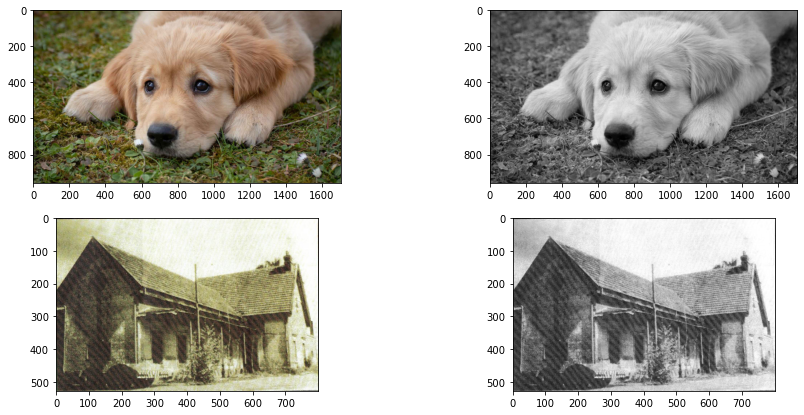

In [49]:
#Ejemplo imagen 1
img_rgb = imageio.imread("perro.jpg")
img = img_rgb[:,:,0]/255

#Ejemplo imagen con interferencias
img_rgb2 = imageio.imread("img_antigua.jpg")
img2 = img_rgb2[:,:,0]/255

#graficos
fig, axes = plt.subplots(2, 2, figsize=(15,7))
axes[0,0].imshow(img_rgb)
axes[0,1].imshow(img, 'gray')
axes[1,0].imshow(img_rgb2)
axes[1,1].imshow(img2, 'gray')

### 1) Calcular y mostrar el espectro en módulo y fase de una imagen en escala de grises.

Text(0.5, 1.0, 'Fase del espectro')

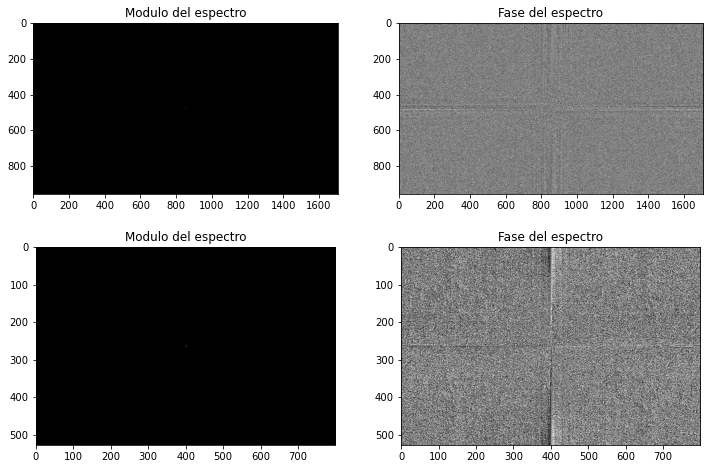

In [24]:
#https://numpy.org/doc/stable/reference/generated/numpy.fft.fft2.html
aux_img1 = np.fft.fft2(img) #trasformada discreta 2D de Fourier
aux_img1 = np.fft.fftshift(aux_img1) #para colocar el componente de frecuencia cero al centro del espectro 
modulo1 = np.abs(aux_img1)
fase1 = np.angle(aux_img1)

aux_img2 = np.fft.fft2(img2) #trasformada discreta 2D de Fourier
aux_img2 = np.fft.fftshift(aux_img2) #para colocar el componente de frecuencia cero al centro del espectro
modulo2 = np.abs(aux_img2)
fase2 = np.angle(aux_img2)

#graficos
fig, axes = plt.subplots(2, 2, figsize=(12,8))
axes[0,0].imshow(modulo1,'gray')
axes[0,0].set_title("Modulo del espectro")
axes[0,1].imshow(fase1,'gray')
axes[0,1].set_title("Fase del espectro")
axes[1,0].imshow(modulo2,'gray')
axes[1,0].set_title("Modulo del espectro")
axes[1,1].imshow(fase2,'gray')
axes[1,1].set_title("Fase del espectro")
#se representa la energía a cada una de las frecuencias con niveles de grices

### 2) Mostrar el módulo en escala logarítmica

Text(0.5, 1.0, 'Modulo del espectro logaritmico')

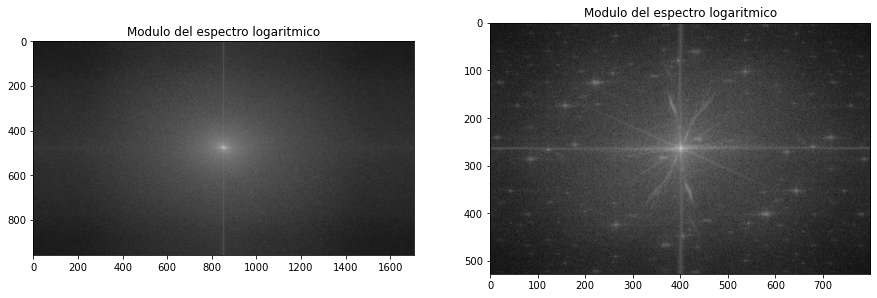

In [25]:
#Como podemos ver arriba el modulo no se puede apreciar por lo que se le aplica una función logaritmica
alpha=1
beta=500
Im_log1 = np.log10(alpha+modulo1)*beta
modulo_log1 = Im_log1/Im_log1.max()
Im_log2 = np.log10(alpha+modulo2)*beta
modulo_log2 = Im_log2/Im_log2.max()

#graficos
fig, axes = plt.subplots(1, 2, figsize=(15,7))
axes[0].imshow(modulo_log1,'gray')
axes[0].set_title("Modulo del espectro logaritmico")
axes[1].imshow(modulo_log2,'gray')
axes[1].set_title("Modulo del espectro logaritmico")

#acá en la primer imagen podemos ver que la cruz que se forma con las lineas blancas que corresponde a la diferencia 
#de luminancia entre los extremos izquierdo y derecho de la imagen y los extremos superior e inferior de la imagen. 
#Si prestamos atención a la imagen del perro en escala de grices, la diferencia de brillo en los extremos
#"este y oeste" es poca,por eso la recta horiontal no esta tan marcada como la vertical, donde si hay más
#diferencia ya que se pasa de una luminancia en el lomo del perro a tener pasto en el extremo sur.

#en la segunda imagen hay más frecuencias indeseadas por lo que luego de guardarla se la editara en paint

### 3) Guardar el espectro como imagen .png y modificarla (filtros) 

In [58]:
plti.imsave("espectro.png", modulo_log1, cmap='gray')
plti.imsave("espectro_2.png", modulo_log2, cmap='gray')

# width, height = img_aux.size
# img_aux = img_aux.resize((width, height),Image.ANTIALIAS)
# img_aux.save("espectro.png")

### 4) Implementar la transformada inversa que convierta el espectro guardado en la imagen original

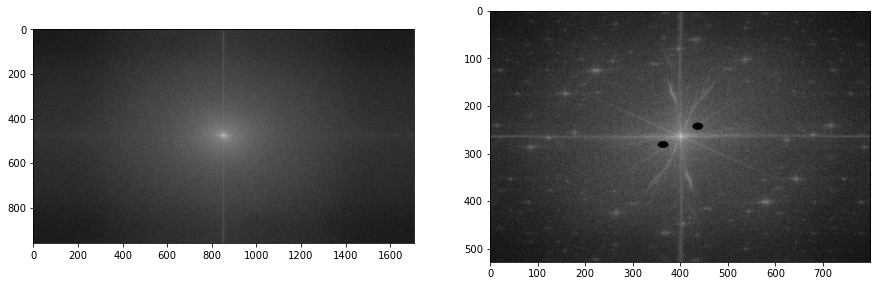

In [60]:
img_guardada = imageio.imread("espectro.png")[:,:,0]/255
img_guardada = img_guardada*2900  #escalado para recuperar la perdida de calidad por guardar la imagen 

img_guardada2 = imageio.imread("espectro_2mod.png")[:,:,0]/255
img_guardada2 = img_guardada2*2700  #escalado para recuperar la perdida de calidad por guardar la imagen 

#graficos
fig, axes = plt.subplots(1, 2, figsize=(15,7))
axes[0].imshow(img_guardada,'gray')
axes[1].imshow(img_guardada2,'gray')

0.10152656338086129
0.027368940055557903


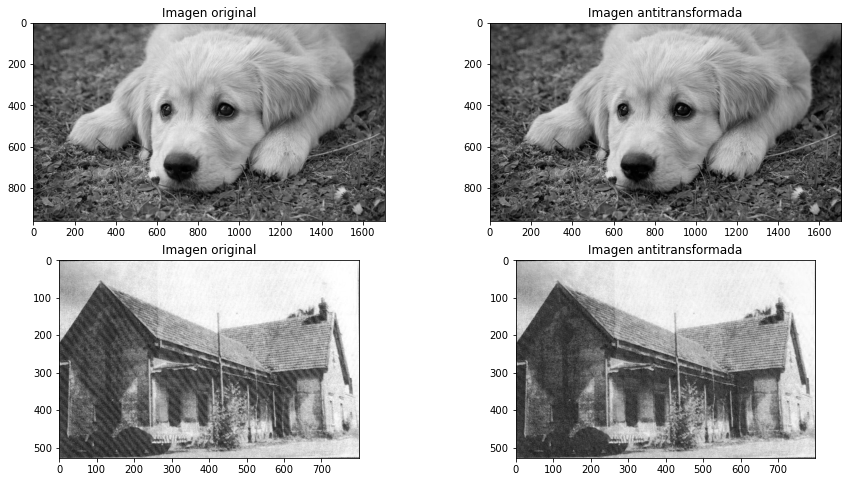

In [61]:
IIm = 10**(img_guardada/beta)-alpha #inversa del modulo
spectrum1 = IIm * np.exp(1j * fase1) #se agrega la parte imaginaria al espectro
IIm2 = 10**(img_guardada2/beta)-alpha
spectrum2 = IIm2 * np.exp(1j * fase2)

#anti transformada del espectro y ya centrado 
recuperacion1 = np.fft.ifft2(np.fft.ifftshift(spectrum1)) 
recuperacion2 = np.fft.ifft2(np.fft.ifftshift(spectrum2)) 

#graficos
fig, axes = plt.subplots(2, 2, figsize=(15,8))
axes[0,0].imshow(img,'gray')
axes[0,0].set_title("Imagen original")
axes[0,1].imshow(np.abs(recuperacion1), 'gray')
axes[0,1].set_title("Imagen antitransformada")
axes[1,0].imshow(img2,'gray')
axes[1,0].set_title("Imagen original")
axes[1,1].imshow(np.abs(recuperacion2), 'gray')
axes[1,1].set_title("Imagen antitransformada")

print(rmse(img,np.abs(recuperacion1)))
print(rmse(img2,np.abs(recuperacion2)))

#se puede ver que se logra recuperar la imagen casi en su totalidad (ya que hay un 0,1 de error medio cuadrático)
#si prestamos atención a la casa, al modificar con paint los puntos de frecuencias indeseadas se puede ver que al 
#recuperar la imagen mejora mucho, sobre todo si se hace foco en la interferencia que habia en la pared 
#de la izquierda de la imagen.